In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import spacy
from spacy import displacy
import scattertext as st
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from time import time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn

In [2]:
covid = pd.read_csv('Corona_NLP_train.csv', encoding = 'latin-1', sep=',')
covid_test = pd.read_csv('Corona_NLP_test.csv', encoding = 'latin-1', sep=',')
covid.head(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news of the regionÂs first confirmed COVID...,Positive
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,Positive
7,3806,48758,Austria,16-03-2020,Was at the supermarket today. Didn't buy toile...,Neutral
8,3807,48759,"Atlanta, GA USA",16-03-2020,Due to COVID-19 our retail store and classroom...,Positive
9,3808,48760,"BHAVNAGAR,GUJRAT",16-03-2020,"For corona prevention,we should stop to buy th...",Negative


## 1. Concatenate the following three columns into a new column of Tweet_texts: Location, TweetAt, OriginalTweet
Note: Question 2.1 has been moved to after question 2.5

In [3]:
columns = ['Location','TweetAt','OriginalTweet']
covid['Tweet_texts'] = covid[columns].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
covid_test['Tweet_texts'] = covid_test[columns].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

## 2. Clean and preprocess the new column of Tweet_texts

### 2.2 Remove the date and time in the tweets using a regular expression

In [4]:
pattern = r"\d{2}-\d{2}-\d{4}"
covid['Tweet_texts'] = covid['Tweet_texts'].apply(lambda row: re.sub(pattern,"",row))
covid_test['Tweet_texts'] = covid_test['Tweet_texts'].apply(lambda row: re.sub(pattern,"",row))

### 2.3 Remove the hyperlink URL in the tweets using a regular expression

In [5]:
pattern = r"https?://[^' ']*"
covid['Tweet_texts'] = covid['Tweet_texts'].apply(lambda row: re.sub(pattern,"",row))
covid_test['Tweet_texts'] = covid_test['Tweet_texts'].apply(lambda row: re.sub(pattern,"",row))

### 2.4 Remove the Twitter hashtags in the tweets using a regular expression

In [6]:
pattern = r"(#[A-Za-z]\w*|#\w*[A-Za-z]\w*?)"
covid['Tweet_texts'] = covid['Tweet_texts'].apply(lambda row: re.sub(pattern,"",row))
covid_test['Tweet_texts'] = covid_test['Tweet_texts'].apply(lambda row: re.sub(pattern,"",row))

### 2.5 Remove the usernames using a regular expression

In [7]:
pattern = r"@\w{1,15}"
covid['Tweet_texts'] = covid['Tweet_texts'].apply(lambda row: re.sub(pattern,"",row))
covid_test['Tweet_texts'] = covid_test['Tweet_texts'].apply(lambda row: re.sub(pattern,"",row))

### 2.1 Remove all special characters, punctuation using a regular expression

In [8]:
pattern = r"[^0-9A-Za-z \t]"
covid['Tweet_texts'] = covid['Tweet_texts'].apply(lambda row: re.sub(pattern,"",row))
covid_test['Tweet_texts'] = covid_test['Tweet_texts'].apply(lambda row: re.sub(pattern,"",row))

### 2.6 Remove all words containing at most two characters

In [9]:
pattern = r"\b[A-Za-z]{1,2}\b|nan"
covid['Tweet_texts'] = covid['Tweet_texts'].apply(lambda row: re.sub(pattern,"",row))
covid_test['Tweet_texts'] = covid_test['Tweet_texts'].apply(lambda row: re.sub(pattern,"",row))

### 2.6.5 Remove extra spaces

In [10]:
pattern = r"\s+"
covid['Tweet_texts'] = covid['Tweet_texts'].apply(lambda row: re.sub(pattern," ",row).strip())
covid_test['Tweet_texts'] = covid_test['Tweet_texts'].apply(lambda row: re.sub(pattern," ",row).strip())

### 2.7 Remove all rows without any text left in the column of Tweet_texts

In [11]:
drop_blank = covid[covid['Tweet_texts'] == ''].index
covid.drop(drop_blank, inplace = True)
covid.reset_index(inplace = True, drop = True)

drop_blank = covid_test[covid_test['Tweet_texts'] == ''].index
covid_test.drop(drop_blank, inplace = True)
covid_test.reset_index(inplace = True, drop = True)

### 2.8 Perform the part of speech tagging for the texts

In [12]:
nlp = spacy.load('en_core_web_lg')
stop_words = nlp.Defaults.stop_words

def nlp_text(text):
    processed = nlp(text)
    return processed

In [13]:
t0 = time()
covid['Tweet_texts'] = covid.Tweet_texts.apply(nlp_text)
covid_test['Tweet_texts'] = covid_test.Tweet_texts.apply(nlp_text)
print(time() - t0)

542.7594559192657


In [14]:
type(covid_test['Tweet_texts'][0])

spacy.tokens.doc.Doc

In [15]:
for i in range(0,20):
    for word in covid.Tweet_texts[i]:
        print(f"Word: {word.text}, Lemma: {word.lemma_}, POS: {word.pos_}, Tag: {word.tag_}, DEP: {word.dep_}, Shape: {word.shape_}, Is Alpha: {word.is_alpha}, Is Stop: {word.is_stop}")

Word: London, Lemma: London, POS: PROPN, Tag: NNP, DEP: ROOT, Shape: Xxxxx, Is Alpha: True, Is Stop: False
Word: and, Lemma: and, POS: CCONJ, Tag: CC, DEP: cc, Shape: xxx, Is Alpha: True, Is Stop: True
Word: and, Lemma: and, POS: CCONJ, Tag: CC, DEP: cc, Shape: xxx, Is Alpha: True, Is Stop: True
Word: advice, Lemma: advice, POS: NOUN, Tag: NN, DEP: nsubj, Shape: xxxx, Is Alpha: True, Is Stop: False
Word: Talk, Lemma: talk, POS: VERB, Tag: VB, DEP: ROOT, Shape: Xxxx, Is Alpha: True, Is Stop: False
Word: your, Lemma: your, POS: PRON, Tag: PRP$, DEP: poss, Shape: xxxx, Is Alpha: True, Is Stop: True
Word: neighbours, Lemma: neighbour, POS: NOUN, Tag: NNS, DEP: dobj, Shape: xxxx, Is Alpha: True, Is Stop: False
Word: family, Lemma: family, POS: NOUN, Tag: NN, DEP: nsubj, Shape: xxxx, Is Alpha: True, Is Stop: False
Word: exchange, Lemma: exchange, POS: NOUN, Tag: NN, DEP: compound, Shape: xxxx, Is Alpha: True, Is Stop: False
Word: phone, Lemma: phone, POS: NOUN, Tag: NN, DEP: compound, Shape:

### 2.10 Perform the named entities recognition for the texts

In [16]:
for i in range(0,20):
    for ent in covid.Tweet_texts[i].ents:
        print(f'Text: {ent.text}\nLabel: {ent.label_}\n')

Text: London
Label: GPE

Text: Vagabonds Coronavirus Australia
Label: ORG

Text: 3631970882363649
Label: CARDINAL

Text: first
Label: ORDINAL

Text: COVID19
Label: PERSON

Text: Sullivan County
Label: GPE

Text: last week
Label: DATE

Text: 3592654178753267
Label: CARDINAL

Text: Austria
Label: GPE

Text: today
Label: DATE

Text: Atlanta USA
Label: ORG

Text: Atlanta
Label: GPE

Text: the next two weeks
Label: DATE

Text: Monday March 16
Label: DATE

Text: Makati
Label: GPE

Text: All month
Label: DATE

Text: all the hours
Label: TIME

Text: Pitt Meadows Canada
Label: ORG

Text: Chicago
Label: GPE

Text: Ill
Label: ORG

Text: Amazon
Label: ORG

Text: Amazon
Label: ORG

Text: Houston Texas Lines
Label: ORG

Text: Saudi Arabia
Label: GPE

Text: Ontario
Label: GPE

Text: Canada
Label: GPE

Text: Russia
Label: GPE

Text: Arctic
Label: LOC

Text: Iran
Label: GPE

Text: 101
Label: CARDINAL

Text: North America Amazon Glitch Stymies Whole Foods Fresh Grocery
Label: ORG

Text: Today
Label: DAT

### 2.11 Visualize the GEOLOCATION, MONEY, and QUANTITY in the texts

In [17]:
colors = {"LOC": "#EBD2B4",
          "MONEY": "#9BFBE1",
          "QUANTITY": "#F6A5EB"}
          
options = {"ents": ['LOC','MONEY','QUANTITY'],
           "colors": colors}

for i in range(0,20):
    displacy.render(covid.Tweet_texts[i], style="ent", jupyter = True, options = options)

C:\Users\Justin\anaconda3\lib\site-packages\spacy\displacy\__init__.py:200: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


## 3. Extract all the tokens from the Tweet_texts

In [18]:
covid['tokens'] = covid['Tweet_texts']
covid_test['tokens'] = covid_test['Tweet_texts']

## 4. Replace the Tweet_texts column with the string only containing the lemmas of all the tokens

In [19]:
stop_words = nlp.Defaults.stop_words
def get_lemma(sentence):
    text = [word.lemma_ for word in sentence if word not in stop_words]
    return ' '.join(text).strip().lower()

covid['Tweet_texts'] = covid.Tweet_texts.apply(get_lemma)
covid_test['Tweet_texts'] = covid_test.Tweet_texts.apply(get_lemma)

## 5. Graphically summarize the Sentiment

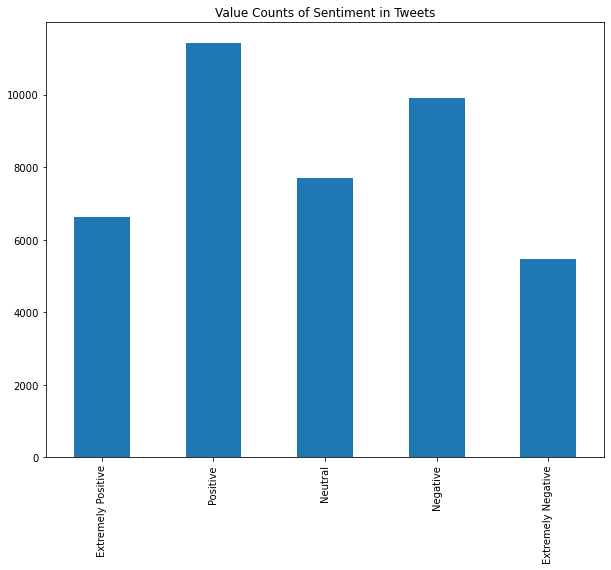

In [20]:
covid.Sentiment = pd.Categorical(covid['Sentiment'],
                                 categories=['Extremely Positive', 'Positive', 'Neutral', 'Negative', 'Extremely Negative'],
                                 ordered=True)
covid.Sentiment.value_counts().sort_index().plot(kind='bar',figsize=(10,8))
plt.title('Value Counts of Sentiment in Tweets')
plt.show()

## 6. Graphically summarize the length of the text of the Tweet_texts using...

### 6.1 Boxplot

In [21]:
covid['tweet_length'] = covid['Tweet_texts'].str.len()

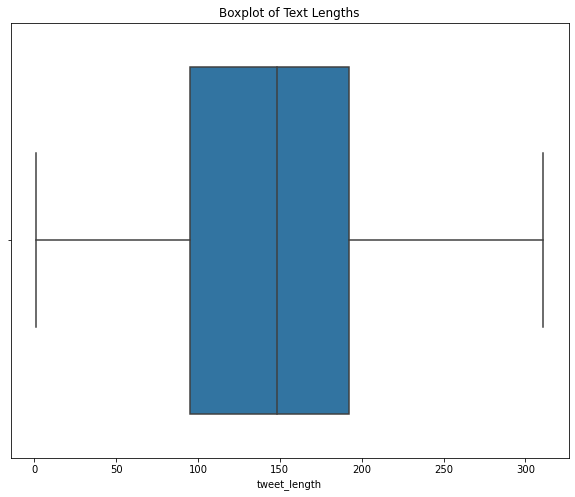

In [22]:
plt.figure(figsize=(10,8))
sns.boxplot(x=covid['tweet_length'])
plt.title('Boxplot of Text Lengths')
plt.show()

### 6.2 Histogram

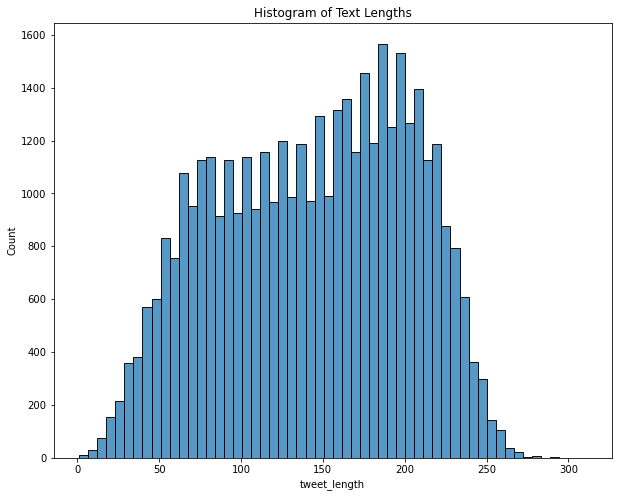

In [23]:
plt.figure(figsize=(10,8))
sns.histplot(x=covid['tweet_length'])
plt.title('Histogram of Text Lengths')
plt.show()

### 6.3 Density Plot

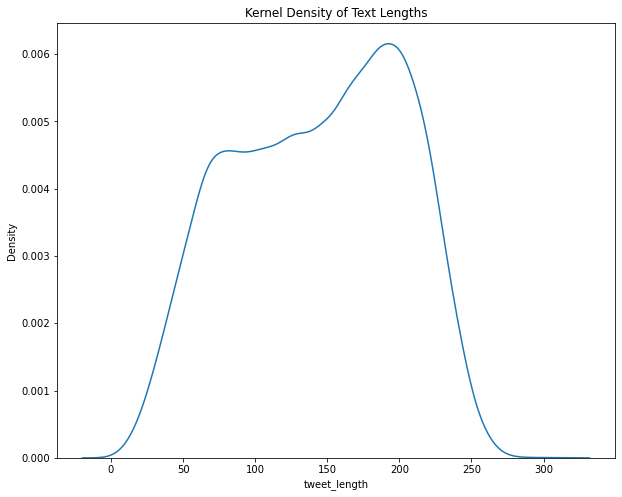

In [24]:
plt.figure(figsize=(10,8))
sns.kdeplot(x=covid['tweet_length'])
plt.title('Kernel Density of Text Lengths')
plt.show()

## 7. Graphically summarize the word count of the text of the Tweet_texts using...

### 7.1 Boxplot

In [25]:
covid['word_count'] = covid['Tweet_texts'].str.split().str.len()

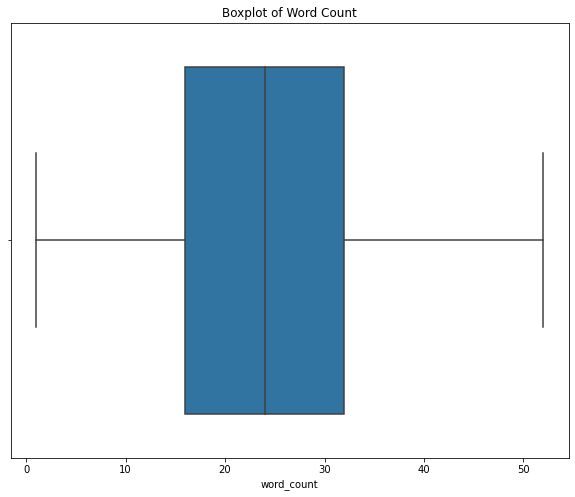

In [26]:
plt.figure(figsize=(10,8))
sns.boxplot(x=covid['word_count'])
plt.title('Boxplot of Word Count')
plt.show()

### 7.2 Histogram

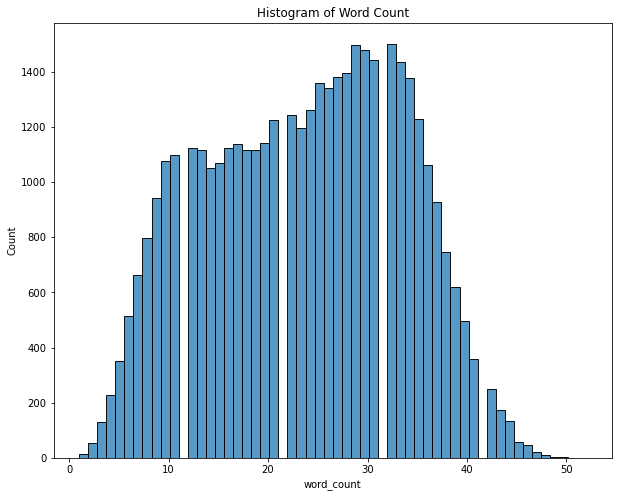

In [27]:
plt.figure(figsize=(10,8))
sns.histplot(x=covid['word_count'])
plt.title('Histogram of Word Count')
plt.show()

### 7.3 Density Plot

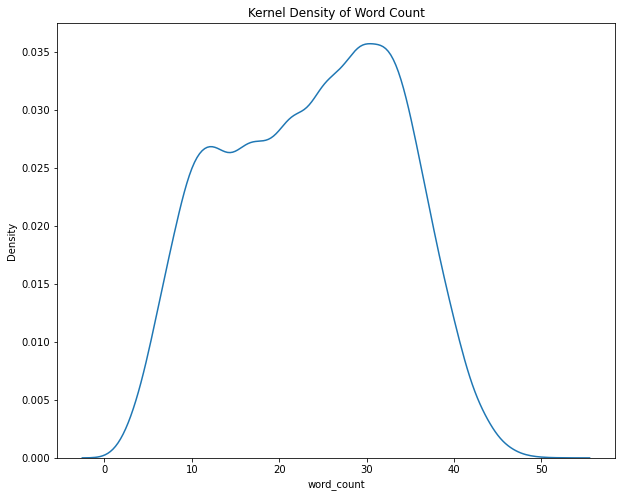

In [28]:
plt.figure(figsize=(10,8))
sns.kdeplot(x=covid['word_count'])
plt.title('Kernel Density of Word Count')
plt.show()

## 8. Graphically summarize the top 10 unigram and bigrams of the tf-idf of the text of the Tweet_texts

In [29]:
def top_tfidf_words(df=covid, col='Tweet_texts', use_idf=True, ngram_range=(1,1), top_n=10):
    
    tfidf = TfidfVectorizer(stop_words='english', ngram_range=ngram_range, use_idf=use_idf)
    
    sparse_matrix = tfidf.fit_transform(df[col])
    features = np.array(tfidf.get_feature_names())
    
    tfidf_sparse_matrix = tfidf.transform(df[col])
    sorted_idx = np.argsort(-tfidf_sparse_matrix.data)[:top_n]
    
    return pd.DataFrame( {
        'feature': features[tfidf_sparse_matrix.indices[sorted_idx]],
        'tf_idf': tfidf_sparse_matrix.data[sorted_idx],
    })

top10 = top_tfidf_words(ngram_range=(1,2))

C:\Users\Justin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


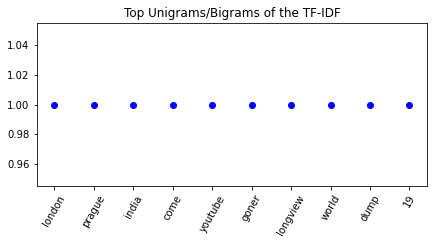

In [30]:
x = range(0,10)

plt.figure(figsize=(7,3))
plt.plot(x, top10.tf_idf,'bo')
plt.xticks(x, labels=top10.feature,rotation=60)
plt.title('Top Unigrams/Bigrams of the TF-IDF')
plt.show()

## 9. Visualize the top 10 term frequency of the tokens associated with positive tweets using scattertext

In [31]:
t0 = time()
corpus = st.CorpusFromPandas(covid,
                             category_col='Sentiment',
                             text_col='Tweet_texts',
                             nlp=nlp).build()

print(time() - t0)

460.4351615905762


In [32]:
term_freq = corpus.get_term_freq_df()
term_freq['Positive Score'] = corpus.get_scaled_f_scores('Positive')

term_freq_freq = term_freq.sort_values(by='Positive freq', ascending=False).head(10)

C:\Users\Justin\anaconda3\lib\site-packages\scattertext\termscoring\ScaledFScore.py:27: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores = np.zeros(len(cat_scores)).astype(np.float)


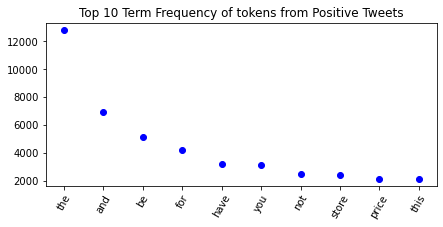

In [33]:
x = range(0,10)

plt.figure(figsize=(7,3))
plt.plot(x, term_freq_freq['Positive freq'],'bo')
plt.xticks(x, labels=term_freq_freq.index,rotation=60)
plt.title('Top 10 Term Frequency of tokens from Positive Tweets')
plt.show()

## 10. Visualize the top 10 positive scores of the tokens associated with positive tweets using scattertext

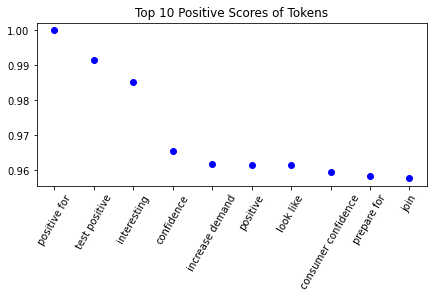

In [34]:
term_freq_score = term_freq.sort_values(by='Positive Score', ascending=False).head(10)

x = range(0,10)

plt.figure(figsize=(7,3))
plt.plot(x, term_freq_score['Positive Score'],'bo')
plt.xticks(x, labels=term_freq_score.index,rotation=60)
plt.title('Top 10 Positive Scores of Tokens')
plt.show()

## 11. Convert the column of the Tweet_texts to a matrix of token counts using CountVectorizer and unigrams and bigrams

In [35]:
vectorizer = CountVectorizer(ngram_range=(1,2))

matrix = vectorizer.fit_transform(covid['Tweet_texts'])
print(f'Size of the feature matrix: {matrix.get_shape()}')

Size of the feature matrix: (41142, 422743)


## 12. Perform the tf-idf analysis on the column of the Tweet_texts using Tfidfvectorizer

In [36]:
tf_idf_transformer = TfidfTransformer(use_idf = True, smooth_idf = True, sublinear_tf = False)

tf_idf_matrix = tf_idf_transformer.fit_transform(matrix)
print(f'Sparse tf_idf matrix with CountVectorizer/TFIDFTransformer:\n{tf_idf_matrix}')

Sparse tf_idf matrix with CountVectorizer/TFIDFTransformer:
  (0, 215635)	0.6336844523850849
  (0, 215606)	0.3191309994338385
  (0, 28588)	0.6450742554399274
  (0, 28328)	0.2836875481483069
  (1, 421234)	0.1303012405715499
  (1, 420505)	0.048566057646931025
  (1, 411896)	0.14725296089548318
  (1, 410677)	0.042010149547399275
  (1, 356052)	0.14142145707536902
  (1, 355930)	0.0824956416527962
  (1, 352026)	0.1572219825215275
  (1, 351670)	0.05938818559301778
  (1, 325856)	0.13728393926943885
  (1, 325842)	0.05389624495334442
  (1, 321945)	0.13558995325525483
  (1, 321820)	0.08327325038182266
  (1, 316053)	0.1572219825215275
  (1, 316014)	0.08755163374149094
  (1, 299737)	0.1572219825215275
  (1, 299694)	0.09763434969923625
  (1, 280402)	0.1572219825215275
  (1, 280401)	0.15139047870141334
  (1, 274621)	0.28808730551103967
  (1, 274562)	0.18615006912932341
  (1, 263355)	0.1572219825215275
  :	:
  (41141, 95433)	0.1481614815080444
  (41141, 95362)	0.0890485332670208
  (41141, 94466)	0.1113

## 13. Find the cosine similarity in Tweet_texts between the 200th and 20,000th tweets

In [37]:
doc1 = nlp(covid['Tweet_texts'][199])
doc2 = nlp(covid['Tweet_texts'][19999])

spacy_sim = doc1.similarity(doc2)

print('Tweets to be analyzed')
print(f'Tweet 200:\t{covid["Tweet_texts"][199]}\n\nTweet 20,000:\t{covid["Tweet_texts"][19999]}\n')
print(f'The cosine similarity between the two tweets using the Spacy function is {spacy_sim}')  

Tweets to be analyzed
Tweet 200:	cambridge our retail store will close through the end march be do this keep our staff and customer safe during the covid19 crisis will continue fulfill and ship out order place online pickups will not available until return regular hour

Tweet 20,000:	two supermarket van be destroy sickening arson attack bristol and police riot van be call out soon after boris johnson announce the new restriction

The cosine similarity between the two tweets using the Spacy function is 0.8150188512496247


## 14. Find the corpus vector equal to the average of all the document vectors, where each document corresponds to a tweet or a row in this dataset

In [38]:
average = np.array([token.vector for token in covid['tokens']]).mean(axis=0)
print(f'The corpus vector/average of all document vectors is:\n{average}')

The corpus vector/average of all document vectors is:
[-8.45651776e-02  1.10172071e-01 -6.77762106e-02 -6.66793883e-02
  9.54915881e-02 -3.32688913e-02 -2.28585433e-02 -4.33275662e-02
  3.19618769e-02  1.95111465e+00 -2.39001274e-01 -3.02418824e-02
  4.03981470e-02 -6.80448115e-02 -8.47371891e-02 -7.64227509e-02
 -7.90635571e-02  1.00455749e+00 -1.01109952e-01  1.97224766e-02
 -1.47814746e-04  3.40176038e-02  2.11600177e-02 -6.34621754e-02
 -1.71765499e-02  1.58358477e-02 -9.92465317e-02 -5.47822304e-02
  1.75456870e-02 -2.96946820e-02 -5.68662807e-02  1.65452473e-02
  1.28542888e-03  1.60646830e-02  6.26878440e-02  2.53784992e-02
 -1.19459303e-02  1.26308315e-02 -1.38385743e-02  4.74752439e-03
 -4.39141095e-02  2.42815446e-02  2.99776383e-02 -4.25442085e-02
  1.45784416e-03  5.90724647e-02 -8.74843225e-02 -1.43517340e-02
  1.22463088e-02  1.03035718e-02 -6.04011677e-02 -1.62730310e-02
  1.64122190e-02 -1.39788296e-02  6.37744218e-02 -3.06658298e-02
 -2.50195116e-02 -6.65646791e-02 -5.

## 15. Build the first model based on the training dataset using the random forests and pipeline

In [39]:
X_train = covid['Tweet_texts']
y_train = covid['Sentiment']
X_test = covid_test['Tweet_texts']
y_test = covid_test['Sentiment']

classifier = RandomForestClassifier()

pipeline = Pipeline([("vectorizer", TfidfVectorizer()),
                     ("classifier", classifier)])

In [40]:
t0 = time()

pipeline.fit(X_train, y_train)

print(time() - t0)

158.16810393333435


## 16. Check the first model on the test dataset. Is it a good model based on the selected evaluation metrics? Please justify your answer.
The accuracy of this model is 46%. Given that there are 5 options I don't think this is a bad score to start out with.

In [41]:
target_names = ['Extremely Positive', 'Positive', 'Neutral', 'Negative', 'Extremely Negative']
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred, target_names = target_names))

                    precision    recall  f1-score   support

Extremely Positive       0.65      0.24      0.36       592
          Positive       0.69      0.31      0.43       599
           Neutral       0.42      0.44      0.43      1041
          Negative       0.51      0.60      0.55       619
Extremely Negative       0.37      0.58      0.46       947

          accuracy                           0.45      3798
         macro avg       0.53      0.44      0.44      3798
      weighted avg       0.50      0.45      0.44      3798



## 17. Create the second model using pipeline, grid search CV for the hyperparameters

In [42]:
t0 = time()
parameters = {
    'vectorizer__max_df': (0.5,1.0),
    'vectorizer__ngram_range':((1,1),(1,2)),
    'classifier__criterion':('gini','entropy'),
    'classifier__n_estimators':(10,100),
    'classifier__max_depth':(15,None)
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs =-1, verbose=1)
grid_search.fit(X_train, y_train)


print(time() - t0)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
4409.334873914719


In [43]:
best_parameters = grid_search.best_estimator_.get_params()
print(f'Best Score: {grid_search.best_score_:0.3f}')
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best Score: 0.477
	classifier__criterion: 'gini'
	classifier__max_depth: None
	classifier__n_estimators: 100
	vectorizer__max_df: 0.5
	vectorizer__ngram_range: (1, 1)


## 18. Tune the second model and perform model diagnostics on the test dataset. Is it a good model? Please justify your answer.
Tuning this model didn't seem to make much of a change overall. Mostly because the default choices ended up being the best for this model. It's the same quality as the first model.

In [44]:
target_names = ['Extremely Positive', 'Positive', 'Neutral', 'Negative', 'Extremely Negative']

y_pred = grid_search.predict(X_test)

print(classification_report(y_test, y_pred, target_names = target_names))

                    precision    recall  f1-score   support

Extremely Positive       0.60      0.24      0.35       592
          Positive       0.64      0.27      0.38       599
           Neutral       0.42      0.42      0.42      1041
          Negative       0.53      0.63      0.57       619
Extremely Negative       0.37      0.60      0.46       947

          accuracy                           0.45      3798
         macro avg       0.51      0.43      0.44      3798
      weighted avg       0.49      0.45      0.44      3798



## 19. Build the third model using pipeline, GridSearchCV, hyperparameter for the following classifiers: Logistic Regression, Support Vector Machine, Random Forest

In [45]:
parameters2 = [
    {
        'vectorizer__max_df': [0.5],
        'vectorizer__ngram_range':[(1,1)],
        'classifier':[LogisticRegression()],
        'classifier__solver': ('lbfgs','newton-cg'),
        'classifier__max_iter':(100,500),
        'classifier__C':(1,4),
        'classifier__penalty':('l2','none')
    },
    {
        'vectorizer__max_df': [0.5],
        'vectorizer__ngram_range':[(1,1)],
        'classifier':[SVC()],
        'classifier__gamma':(1,0.1),
        'classifier__kernel':['linear'],
        'classifier__C':(1,4)
    },
    {
        'vectorizer__max_df': [0.5],
        'vectorizer__ngram_range':[(1,1)],
        'classifier':[RandomForestClassifier()],
    }
]
grid_search2 = GridSearchCV(pipeline, parameters2, n_jobs=2, verbose=1)

t0 = time()
grid_search2.fit(X_train, y_train)
print(time() - t0)

print(f'Best Score: {grid_search2.best_score_:0.3f}')

Fitting 5 folds for each of 41 candidates, totalling 205 fits
40371.44542527199
Best Score: 0.602


## 20. Tune the third model and perform model diagnostics on the test dataset. Is it a good model? Please justify your answer.

In [46]:
target_names = ['Extremely Positive', 'Positive', 'Neutral', 'Negative', 'Extremely Negative']

y_pred = grid_search2.predict(X_test)
#y_pred = pipeline.predict(X_train)

print(classification_report(y_test, y_pred, target_names = target_names))

                    precision    recall  f1-score   support

Extremely Positive       0.68      0.52      0.59       592
          Positive       0.70      0.54      0.61       599
           Neutral       0.55      0.56      0.56      1041
          Negative       0.67      0.70      0.68       619
Extremely Negative       0.52      0.64      0.57       947

          accuracy                           0.59      3798
         macro avg       0.62      0.59      0.60      3798
      weighted avg       0.60      0.59      0.59      3798



## 21. Generate the first topic model by setting five topics using LDA method and CountVectorizer

In [47]:
tf_vectorizer = CountVectorizer(max_df = 0.9, min_df = 5, stop_words='english')
document_word_matrix_tf = tf_vectorizer.fit_transform(covid['Tweet_texts'])

lda = LatentDirichletAllocation(n_components = 5, random_state = 69)
lda.fit(document_word_matrix_tf)

LatentDirichletAllocation(n_components=5, random_state=69)

## 22. Plot the top 15 words for each topic for the model above

In [48]:
top_words = 15

for index, topic in enumerate(lda.components_):
    print(f'Top {top_words} words for topic {index}')
    print([tf_vectorizer.get_feature_names()[j] for j in topic.argsort()[-top_words:]])

Top 15 words for topic 0
['good', 'increase', 'essential', 'high', 'make', 'time', 'covid19', 'sell', 'mask', 'people', 'covid', 'amp', 'india', '19', 'price']
Top 15 words for topic 1
['impact', 'make', 'york', 'help', 'coronavirus', '19', 'pandemic', 'use', 'change', 'amp', 'new', 'covid19', 'sanitizer', 'hand', 'consumer']
Top 15 words for topic 2
['stock', 'shelf', 'paper', 'amp', 'toilet', 'work', 'england', 'just', 'worker', 'need', 'buy', 'panic', 'food', 'people', 'supermarket']
Top 15 words for topic 3


C:\Users\Justin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['covid', 'new', 'consumer', 'amid', 'amp', 'increase', '19', 'market', 'supply', 'pandemic', 'oil', 'demand', 'covid19', 'food', 'price']
Top 15 words for topic 4
['order', 'employee', 'worker', 'new', 'people', 'work', '19', 'stay', 'home', 'usa', 'covid19', 'shopping', 'online', 'grocery', 'store']


## 23. Generate the second topic model by setting five topics using LDA method and TfidfVectorizer

In [49]:
tf_vectorizer = TfidfVectorizer(max_df = 0.9, min_df = 5, stop_words='english')
document_word_matrix_tf = tf_vectorizer.fit_transform(covid['Tweet_texts'])

lda = LatentDirichletAllocation(n_components = 5, random_state = 69)
lda.fit(document_word_matrix_tf)

LatentDirichletAllocation(n_components=5, random_state=69)

## 24. Plot the top 15 words for each topic for the second model above

In [50]:
top_words = 15

for index, topic in enumerate(lda.components_):
    print(f'Top {top_words} words for topic {index}')
    print([tf_vectorizer.get_feature_names()[j] for j in topic.argsort()[-top_words:]])

Top 15 words for topic 0
['help', 'government', 'increase', 'people', 'essential', 'consumer', 'supermarket', 'covid', 'store', 'food', 'amp', 'covid19', '19', 'india', 'price']
Top 15 words for topic 1
['alcohol', 'amp', '19', 'wash', 'soap', 'mask', 'covid19', 'new', 'make', 'use', 'san', 'consumer', 'price', 'sanitizer', 'hand']
Top 15 words for topic 2
['shelf', 'just', 'work', 'england', 'paper', 'need', 'toilet', 'buy', 'panic', 'worker', 'food', 'grocery', 'people', 'store', 'supermarket']
Top 15 words for topic 3
['supply', 'amp', 'global', 'crisis', 'market', '19', 'new', 'pandemic', 'impact', 'food', 'oil', 'demand', 'covid19', 'consumer', 'price']
Top 15 words for topic 4
['covid', 'new', 'food', 'amp', 'home', 'usa', 'stay', 'supermarket', '19', 'people', 'covid19', 'shopping', 'online', 'grocery', 'store']


## 25. Visualize the second topic model using the dimension reduction method

In [51]:
pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(lda_model = lda, dtm = document_word_matrix_tf, vectorizer = tf_vectorizer)

C:\Users\Justin\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.162257  0.000527       1        1  28.637819
3     -0.110169 -0.130013       2        1  24.272806
4      0.068946  0.000763       3        1  22.058216
0     -0.015842 -0.010305       4        1  12.980816
1     -0.105192  0.139028       5        1  12.050342, topic_info=           Term        Freq       Total Category  logprob  loglift
3420       hand  481.000000  481.000000  Default  30.0000  30.0000
6318  sanitizer  437.000000  437.000000  Default  29.0000  29.0000
5654      price  966.000000  966.000000  Default  28.0000  28.0000
1763   consumer  643.000000  643.000000  Default  27.0000  27.0000
5098        oil  252.000000  252.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
6046     report   44.113650  183.291997   Topic5  -5.9448   0.6918
7716      virus   43.310841  195.900593   Topic5  -5.9632   0.6069
6444       sell   42.073688  175.064510   Topic5  -5.9922   0.6903
3520       help   43.540769  395.777001   Topic5  -5.9579  -0.0911
5258   pandemic   43.384259  411.461514   Topic5  -5.9615  -0.1335

[428 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
74        1  0.238432    19
74        2  0.249063    19
74        3  0.255137    19
74        4  0.145793    19
74        5  0.110863    19
...     ...       ...   ...
8014      1  0.168510  york
8014      2  0.353871  york
8014      3  0.202212  york
8014      4  0.025276  york
8014      5  0.248552  york

[934 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 5, 1, 2])

In [ ]:
classifier = RandomForestClassifier()

pipeline = Pipeline([("vectorizer", TfidfVectorizer()),
                     ("classifier", classifier)])